In [ ]:
!python --version

Python 3.6.9


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

In [1]:
!git clone https://github.com/dspix/tf-practicals.git

Cloning into 'tf-practicals'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 16 (delta 5), reused 15 (delta 4), pack-reused 0
Unpacking objects: 100% (16/16), done.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%%bash
mkdir data
cp /content/drive/MyDrive/fcn8_train/* /content/data/

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import logging
tf.get_logger().setLevel(logging.ERROR)
import sys
sys.path.append('tf-practicals/code/')
import net
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import shutil
import glob
%matplotlib inline

In [24]:
path = '/content/data/'
all_records = glob.glob(os.path.join(path, '*.tfrecords'))
all_records[:10]

['/content/data/aoi5_khartoum_train_0043.tfrecords',
 '/content/data/aoi5_khartoum_train_0070.tfrecords',
 '/content/data/aoi5_khartoum_train_0114.tfrecords',
 '/content/data/aoi5_khartoum_train_0979.tfrecords',
 '/content/data/aoi5_khartoum_train_0546.tfrecords',
 '/content/data/aoi5_khartoum_train_0486.tfrecords',
 '/content/data/aoi5_khartoum_train_0367.tfrecords',
 '/content/data/aoi5_khartoum_train_0744.tfrecords',
 '/content/data/aoi5_khartoum_train_0942.tfrecords',
 '/content/data/aoi5_khartoum_train_1669.tfrecords']

In [29]:
tf.reset_default_graph()

all_samples = net.get_from_records(
    all_records, # A list of tfrecord filenames
    batch_size=1,
    buffer=1015,
    shuffle=True,
).take(100)

iterator = tf.data.Iterator.from_structure(
    all_samples.output_types,
    all_samples.output_shapes
)

train_samples = all_samples.take(50)
test_samples = all_samples.skip(50)
name, image, label = iterator.get_next()

In [30]:
model = net.inference(tf.cast(image, tf.float32))
batch_labels = net.batch_expand_labels(label, [0, 1])
l = net.loss(model, batch_labels)
train_op = net.train(l, 1e-5) # Learning rate

prediction = tf.argmax(model, axis=3, name="prediction", output_type=tf.int32)

def pixel_accuracy(labels, pred):
    ac = tf.divide(
        tf.reduce_sum(tf.cast(tf.equal(pred, labels), tf.float32)),
        tf.cast(tf.size(labels), tf.float32)
    )
    
    return ac

accuracy = pixel_accuracy(tf.cast(label, tf.int32), prediction)

In [6]:
!mkdir saved_model

In [31]:
epochs = 10
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())# Initialize the model parameters
    for epoch in range(epochs):
        sess.run(iterator.make_initializer(train_samples))
        track_loss = []
        start = dt.now()
        while True:
            try:
                _, loss = sess.run([train_op, l]) 
                track_loss.append(loss)
            except tf.errors.OutOfRangeError:
                break
        mean_loss = np.array(track_loss).mean()
        time_taken = (dt.now() - start).seconds
        print('Epoch: {}, loss: {}, time: {}s'.format(epoch, mean_loss, time_taken))

    # Run the trained model on a test image
    sess.run(iterator.make_initializer(test_samples.take(10)))
    while True:
      try:
        names, img, lab, pred = sess.run([name, image, label, prediction])
      except tf.errors.OutOfRangeError:
        break
    
    # Save the trained model
    save_path = saver.save(sess, "saved_models/model.ckpt")
    print('Model saved to {}'.format(save_path))

Epoch: 0, loss: 0.4093378484249115, time: 49s
Epoch: 1, loss: 0.32663899660110474, time: 46s
Epoch: 2, loss: 0.33703282475471497, time: 37s
Epoch: 3, loss: 0.32461872696876526, time: 36s
Epoch: 4, loss: 0.3051026463508606, time: 36s
Epoch: 5, loss: 0.3299644887447357, time: 34s
Epoch: 6, loss: 0.35890117287635803, time: 34s
Epoch: 7, loss: 0.39201152324676514, time: 34s
Epoch: 8, loss: 0.35825836658477783, time: 34s
Epoch: 9, loss: 0.3165847063064575, time: 34s
Model saved to saved_models/model.ckpt


In [11]:
!ls -1 saved_models

checkpoint
model.ckpt.data-00000-of-00001
model.ckpt.index
model.ckpt.meta


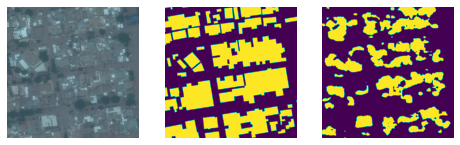

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
plot_n = 0
axes[0].imshow((img[plot_n]+net.MEANS).astype(int))
axes[1].imshow(lab[plot_n])
axes[2].imshow(pred[plot_n])
[ax.axis('off') for ax in axes];
